In [1]:
import arviz as az
# for convergence diagnostics, model checking and summaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import firedocks.pandas as pd
import xarray as xr
import pymc as pm
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.20.1


### A Motivating Example: Linear Regression

In [26]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [64]:
# Linear Regression example 
# Y ~ N(mu, sigma^2) = alpha + beta_1*X_1 + beta_2*X_2 
# where alpha and beta are Normals and sigma is Halfnormal

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100
# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2
# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

# creates a Model object - a container for the model random variables.
basic_model = pm.Model()
# a context manager, includes all statementsuntile the indented block ends. All PyMC objects introduced in the indented code block below the with statement are added to the model behind the scenes.
with basic_model:
    # create stochastic random variables with normally-distributed prior distributions (Priors for unknown model parameters)
    # two priors for coefficients LR
    alpha = pm.Normal(name="alpha", mu=0, sigma=10)
    # The first argument is always the name of the random variable which should almost always match (do not have to) the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output.
    beta = pm.Normal(name="beta", mu=0, sigma=10, shape=2)
    # The shape argument is available for all distributions and specifies the length or shape of the random variable. The default is one for a scalar variable. It can be an integer (for a 1D array) or tuple (for a ndarray)

    # one prior for the standard deviation of the observations
    sigma = pm.HalfNormal(name="sigma", sigma=1)

    # Expected value of outcome
    # creates a deterministic random variable - its value is completely determined by its parents' values.
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations/outcomes
    Y_obs = pm.Normal(name="Y_obs", mu=mu, sigma=sigma, observed=Y)
    # The 'observed' argument indicates that the values for this variable (Y) were observed, and should not be changed by any fitting algorithm applied to the model. 
    # The parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma.

In [65]:
# PyM's "Inference Button" is the call to sample

with basic_model:
    # draw 1000 (default) samples into an InferenceData object
    idata = pm.sample(draws=1000)

# sample generated a set of parallel chains, depending on how many compute cores are on your machine.

# Use the slice sampling algorithm to sample our parameters instead of NUTS (which was assigned automatically)
with basic_model:
    # instantiate sampler
    step = pm.Slice()
    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [66]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [67]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.19077822, 1.19077822, 1.10606604, 1.18527398, 1.14847906],
       [1.34395509, 1.11669153, 1.2098842 , 1.14206601, 1.18965843],
       [1.15217242, 1.21001141, 1.31398334, 0.97255275, 1.11088797],
       [1.05575298, 1.28288691, 0.93085304, 1.03178495, 1.19490681]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

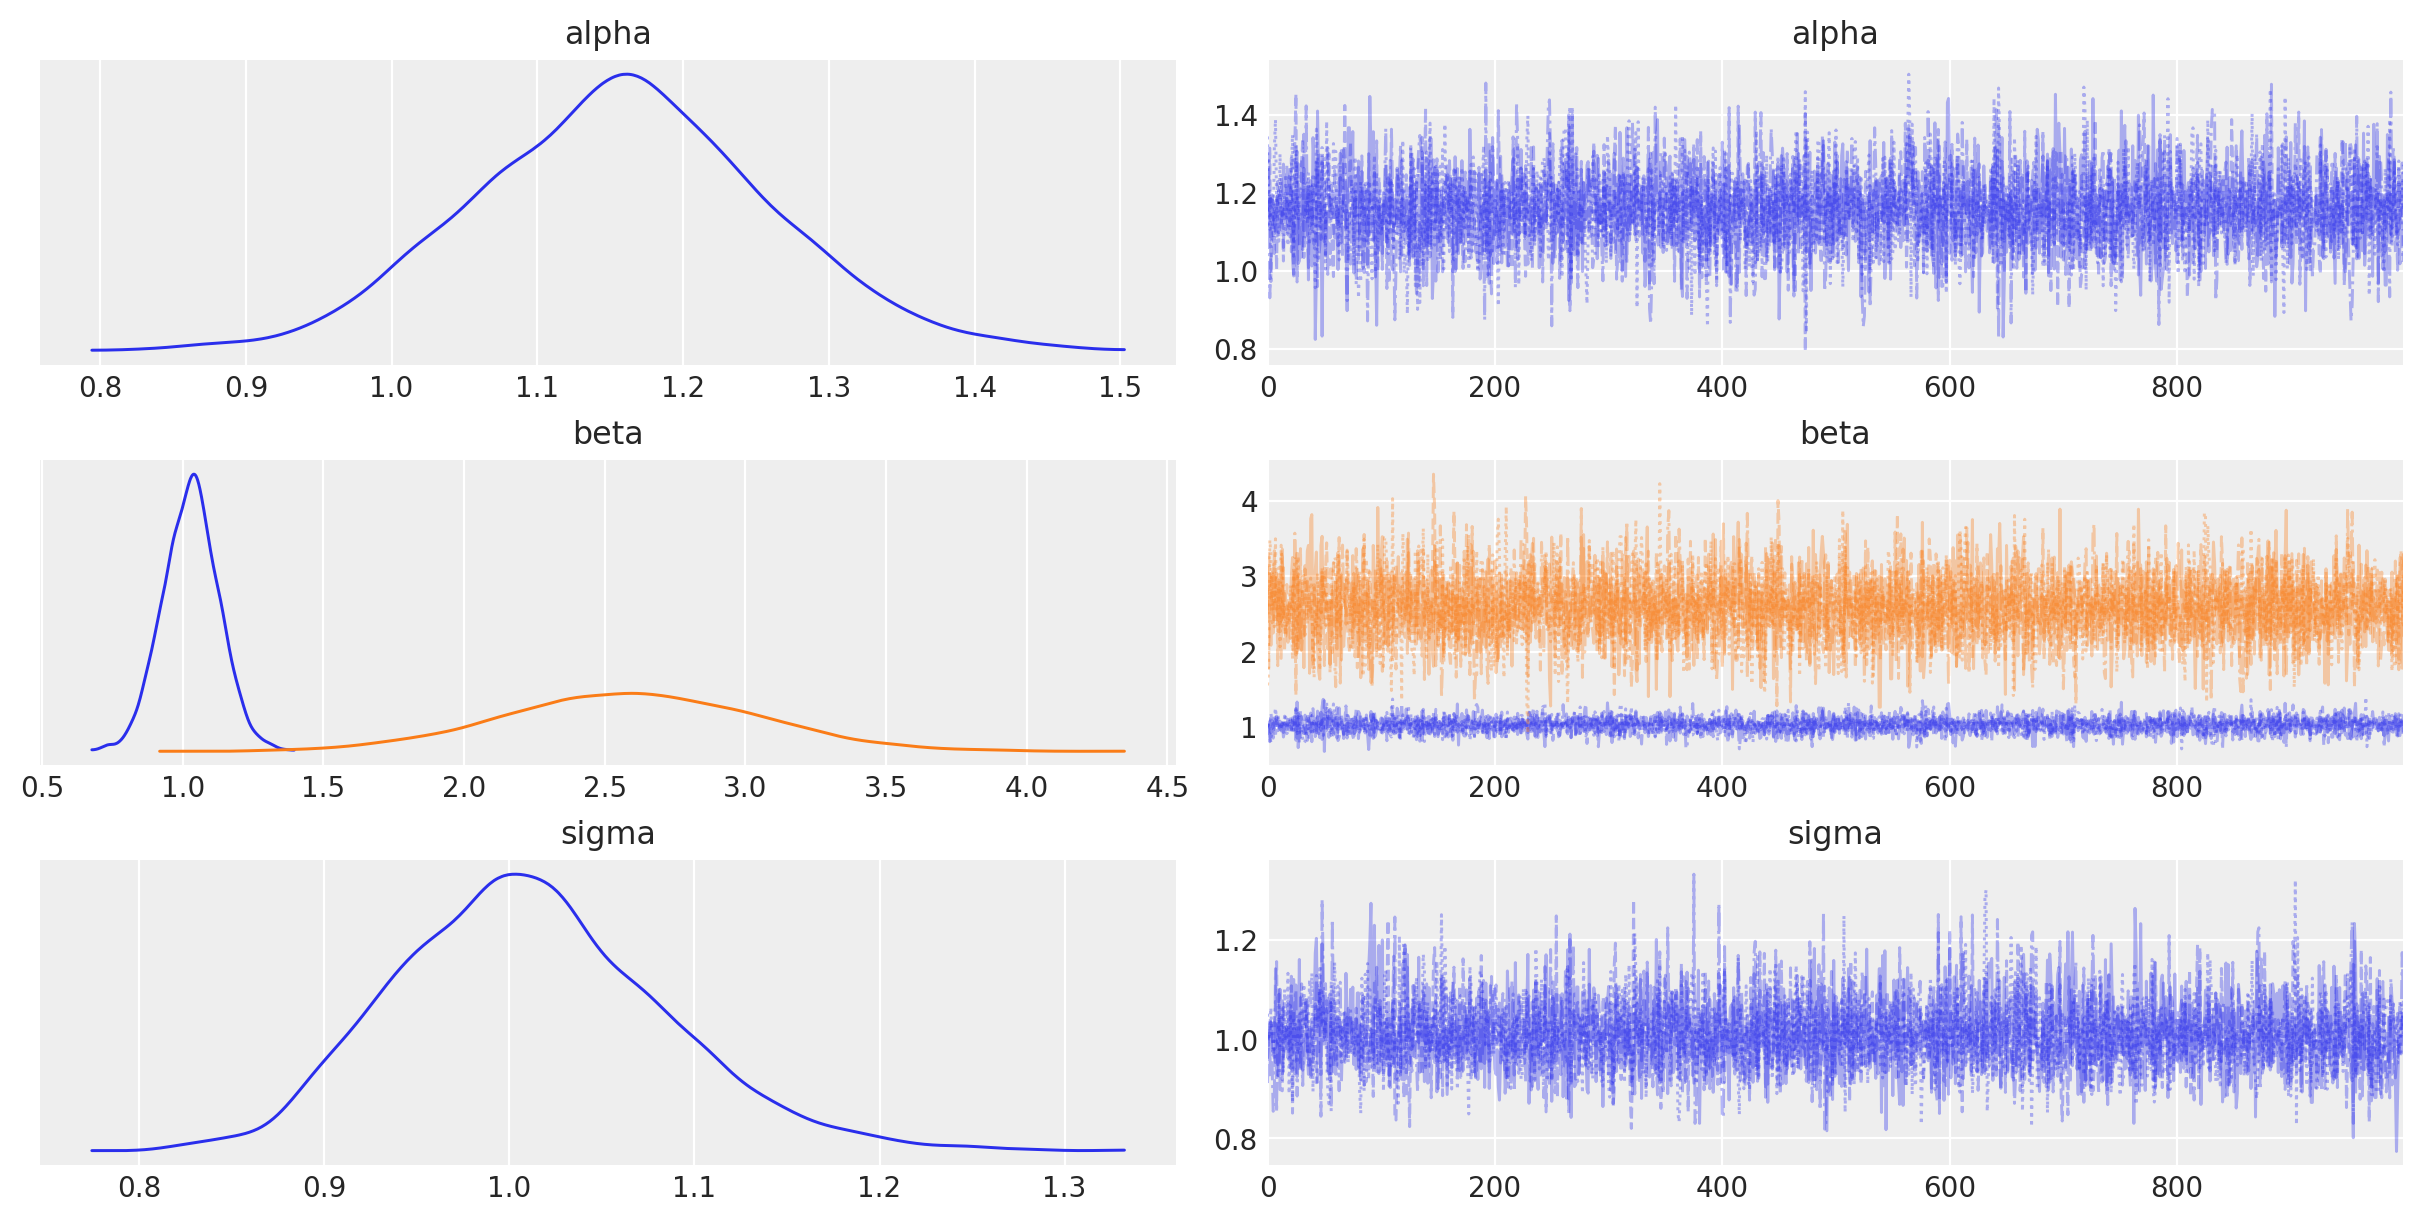

In [68]:
# Arviz provides plotting and diagnostics functionalities. It is a platform-agnostic package
az.plot_trace(idata, combined=True);

# The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In [69]:
# the summary function provides a text-based output of common posterior statistics
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.96,1.34,0.00,0.0,4833.38,3239.82,1.0
beta[0],1.03,0.10,0.84,1.21,0.00,0.0,5518.44,3357.31,1.0
beta[1],2.59,0.45,1.72,3.41,0.01,0.0,5290.88,3176.54,1.0
sigma,1.01,0.07,0.88,1.15,0.00,0.0,5197.67,2959.63,1.0


In [ ]:
# Print the mean and standard deviation of the posterior samples
alpha_mean = np.mean(idata.posterior['alpha'])
sigma_mean = np.mean(idata.posterior['sigma'])
print(f"Estimated mean alpha: {alpha_mean:.2f} cm")
print(f"Estimated standard deviation (sigma): {sigma_mean:.2f} cm")

Estimated mean alpha: 1.16 cm
Estimated standard deviation (sigma): 1.01 cm


### Case study 1: Educational Outcomes for Hearing-impaired Children

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


<Axes: >

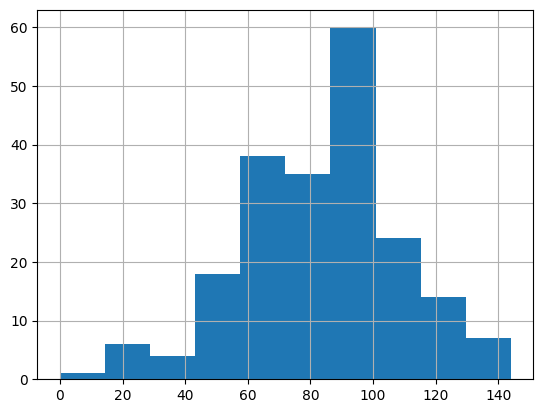

In [9]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
display(test_scores.head())
test_scores["score"].hist()

In [ ]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

# use half the number of predictors -  the parameterization of the prior requires a pre-specified value D0
D0 = int(D / 2)

In [34]:
X.columns

Index(['male', 'siblings', 'family_inv', 'non_english', 'prev_disab',
       'age_test', 'non_severe_hl', 'mother_hs', 'early_ident', 'non_white'],
      dtype='object')

The popular approach for variable selection is regularization. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the hierarchical regularized horseshoe, which uses two regularization strategies, one global and a set of local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero. <br>
In PyMC, variables with purely positive priors like <ins>InverseGamma</ins> are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable-name>_log`) is added to the model for sampling. Variables with priors that constrain them on two sides, like <ins>Beta</ins> or <ins>Uniform</ins>, are also transformed to be unconstrained but with a log odds transform. <br>
We are also going to take advantage of named dimensions in PyMC and ArviZ by passing the input variable names into the model as coordinates called `predictors`. This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating.

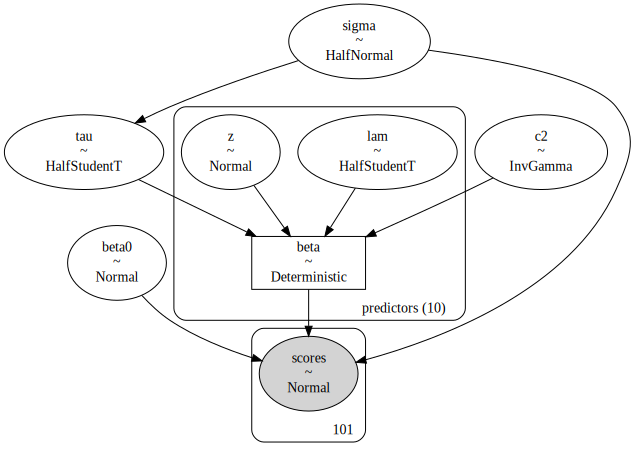

In [51]:
import pytensor.tensor as pt

# a multivariate regression model. 
with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal(name="sigma", sigma=25)

    # hierarchical regularized horseshoe which uses two regularization strategies: one global and a set of local parameters, one for each coefficient.
    # Global shrinkage prior -  the parameterization of the prior requires a pre-specified value D0
    tau = pm.HalfStudentT(name="tau", nu=2, sigma=D0 / (D - D0) * sigma / np.sqrt(N))
    # nu is the Degrees of freedom, also known as normality parameter (nu > 0).

    # Local shrinkage prior
    lam = pm.HalfStudentT(name="lam", nu=5, dims="predictors")
    c2 = pm.InverseGamma(name="c2", alpha=1, beta=1)
    # alpha: Shape parameter. beta: Scale parameter.
    z = pm.Normal(name="z", mu=0.0, sigma=1.0, dims="predictors")

    # Shrunken coefficients
    beta = pm.Deterministic(
        name="beta",
        var=z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # The calculation of beta was wrapped in a Deterministic PyMC class to ensures that the values of this deterministic variable is retained in the sample trace.

    # No shrinkage on intercept
    beta0 = pm.Normal(name="beta0", mu=100, sigma=25.0)

    scores = pm.Normal(
        name="scores", 
        mu=beta0 + pt.dot(X.to_numpy(), beta),
        sigma=sigma,
        observed=y.to_numpy()
        )


pm.model_to_graphviz(test_score_model)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


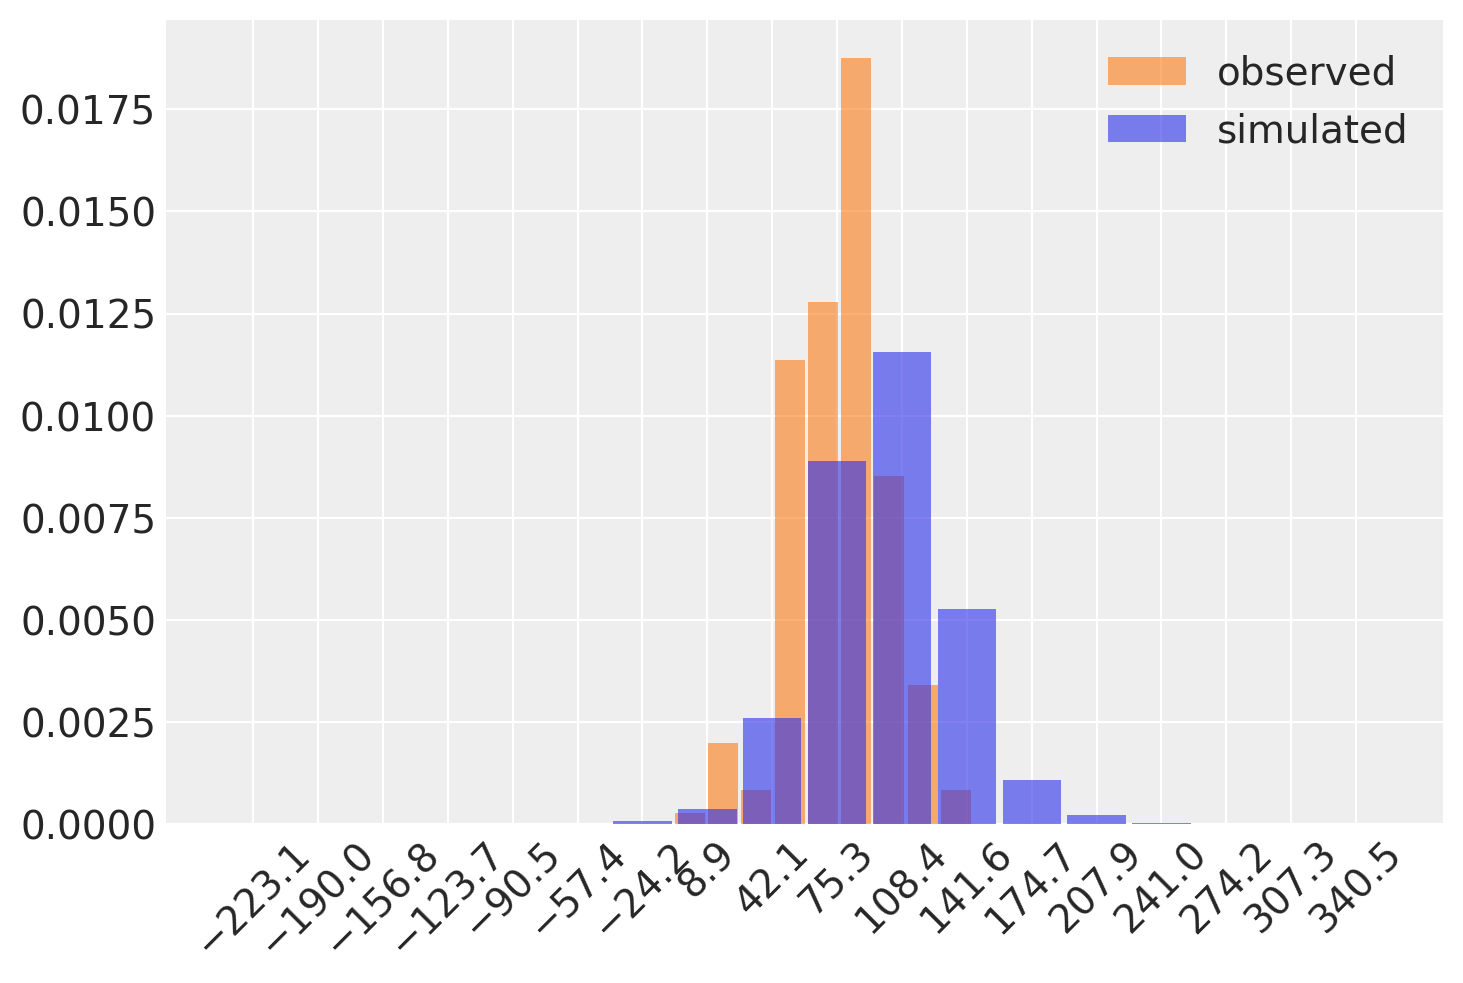

In [50]:
# Conduct prior predictive sampling to generate simulated data from the model. Then, we compare these simulations to the actual test scores in the dataset.

with test_score_model:
    prior_samples = pm.sample_prior_predictive(1000)

az.plot_dist(
    test_scores["score"].to_numpy(),
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
plt.xticks(rotation=45);

# The support of the distribution of simulated data completely overlaps the support of the observed distribution of scores; this is a good sign! There are a few negative values and a few that are probably too large to be plausible, but nothing to worry about.

In [42]:
# model fitting
with test_score_model:
    # we set tune=2000, instead of the default 1000. This gives the NUTS sampler a little more time to tune itself adequately.
    idata = pm.sample(1000, tune=2000, random_seed=42)

    # we have a few warnings here about divergences.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# follow the advice and increase target_accept from its default value of 0.9 to 0.99.
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

# Since the target acceptance rate is larger, the algorithm is being more conservative with its leapfrog steps, making them smaller. The price we pay for this is that each sample takes longer to complete.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


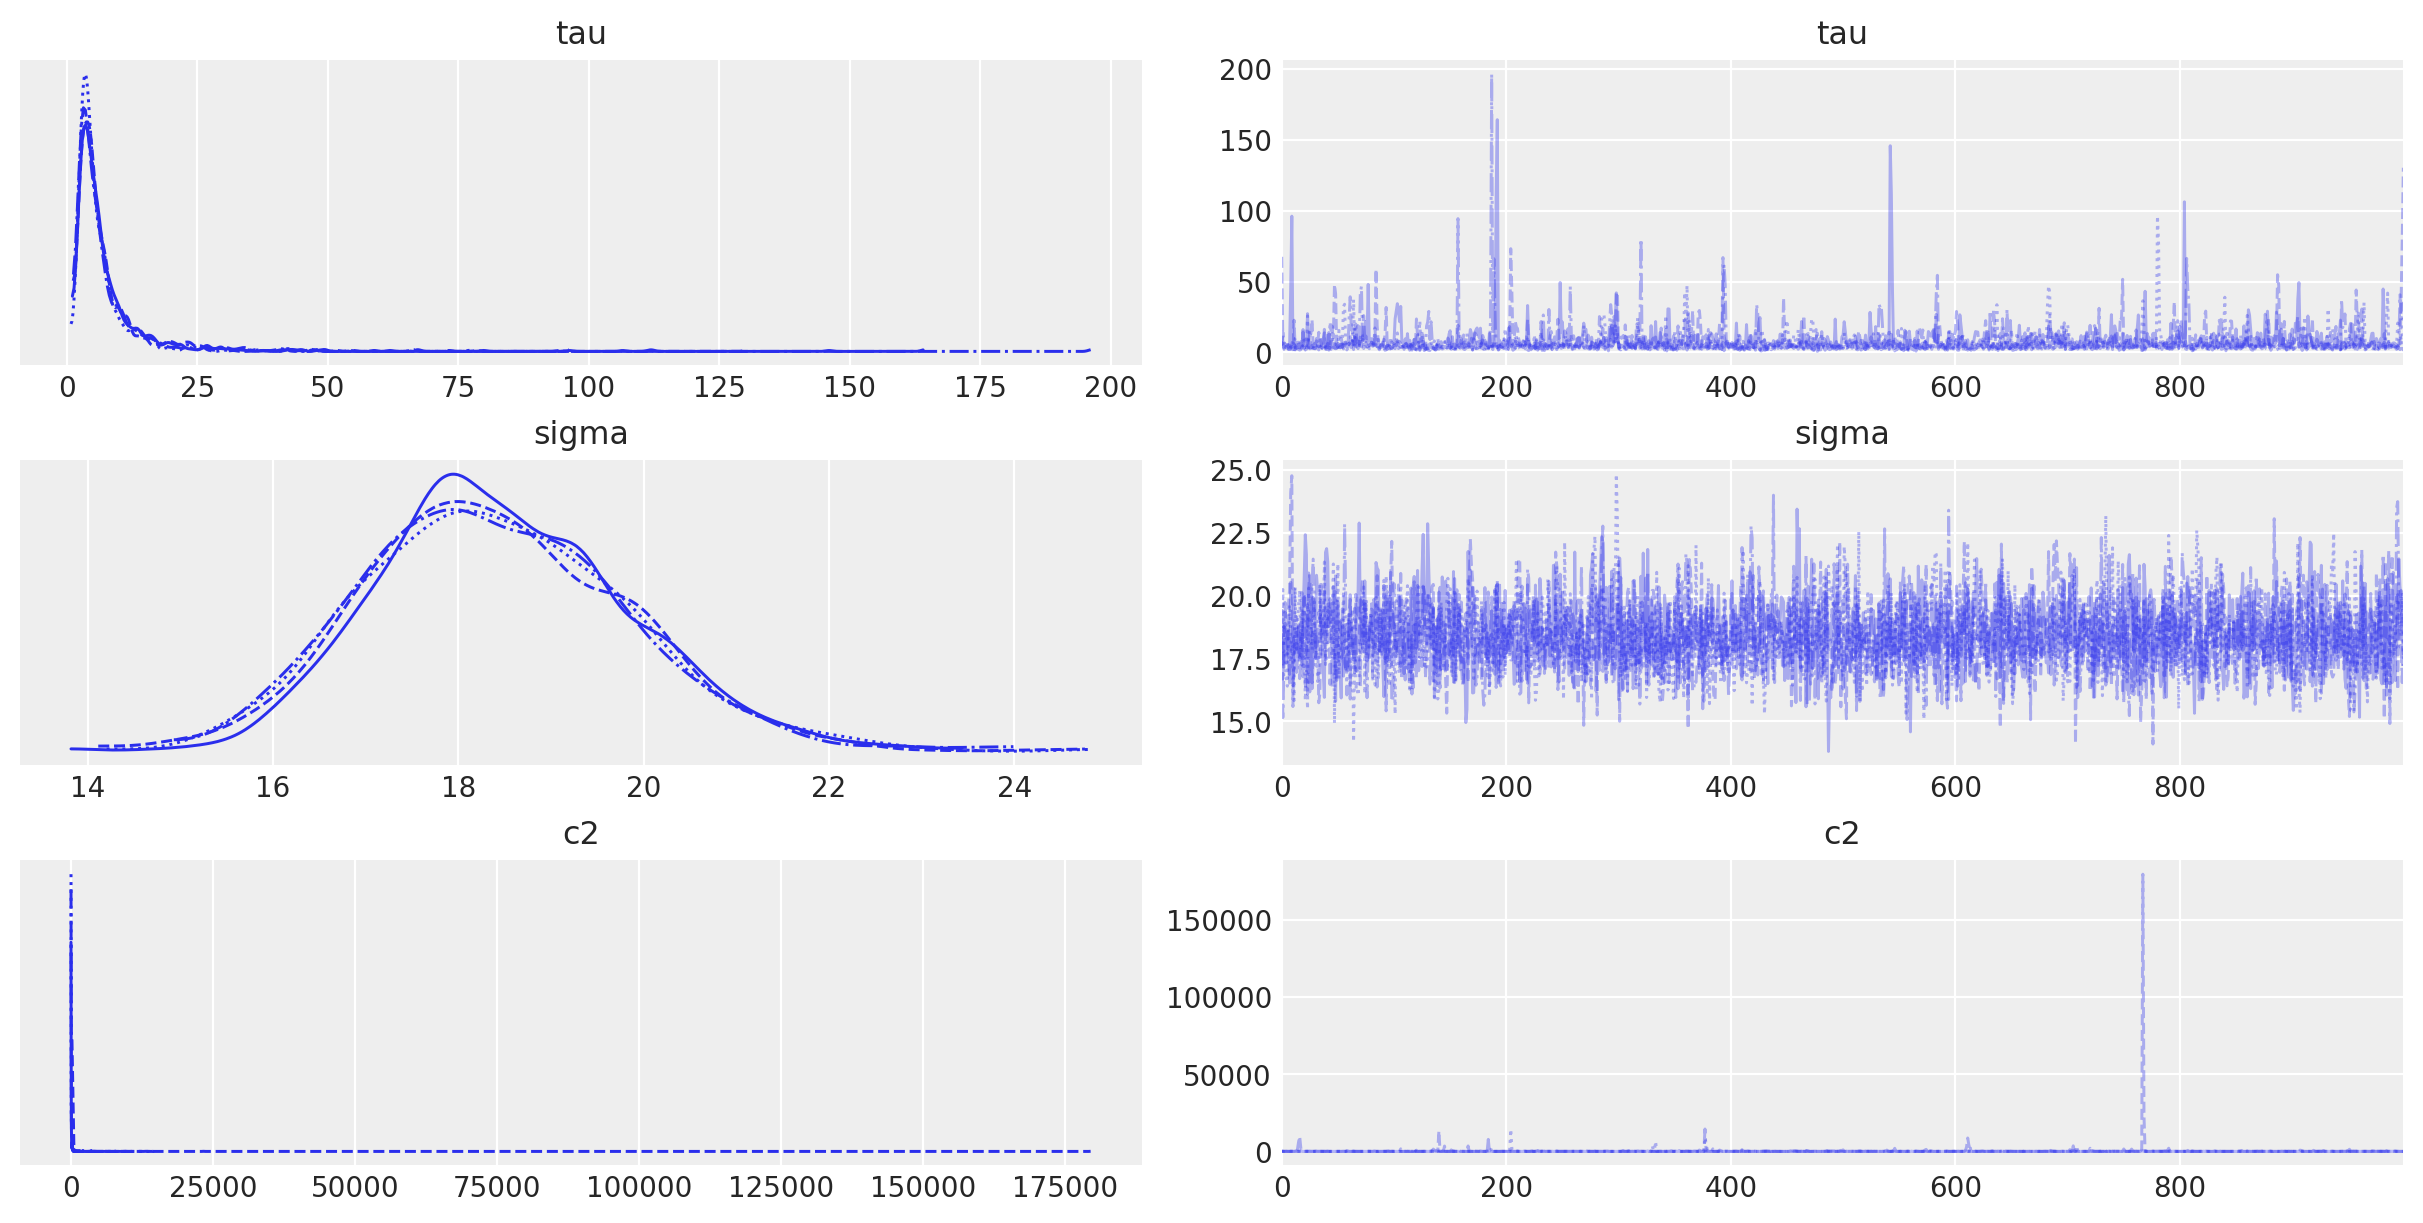

In [ ]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);
# The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that c2 and tau occasionally sample extreme values, but this is expected from heavy-tailed distributions.

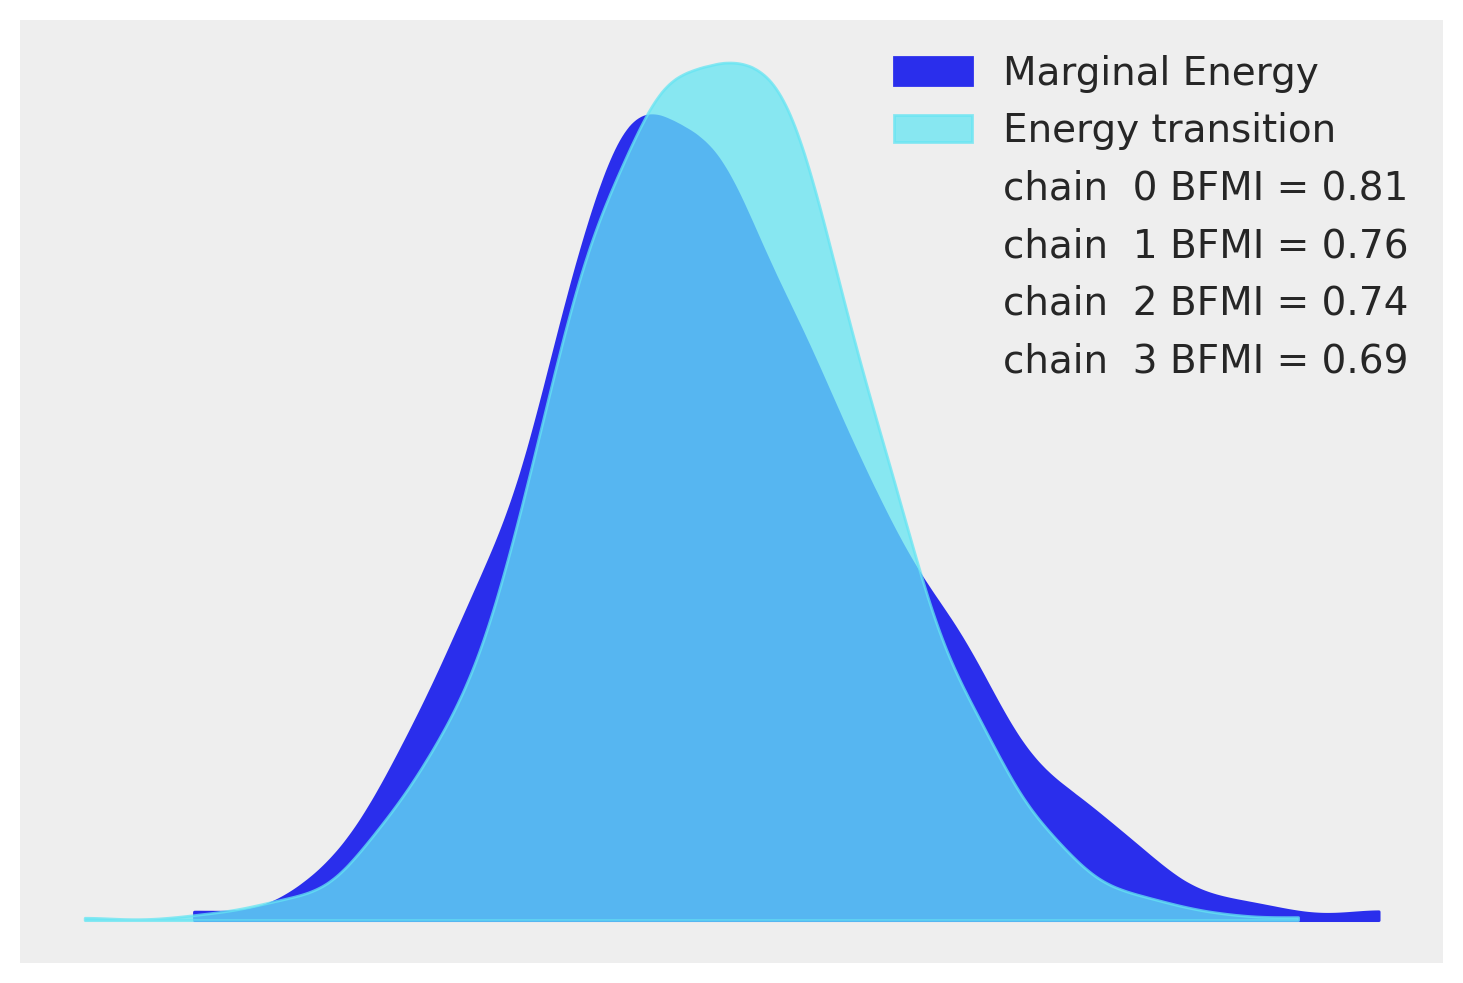

In [ ]:
# An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. 

az.plot_energy(idata);
# all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

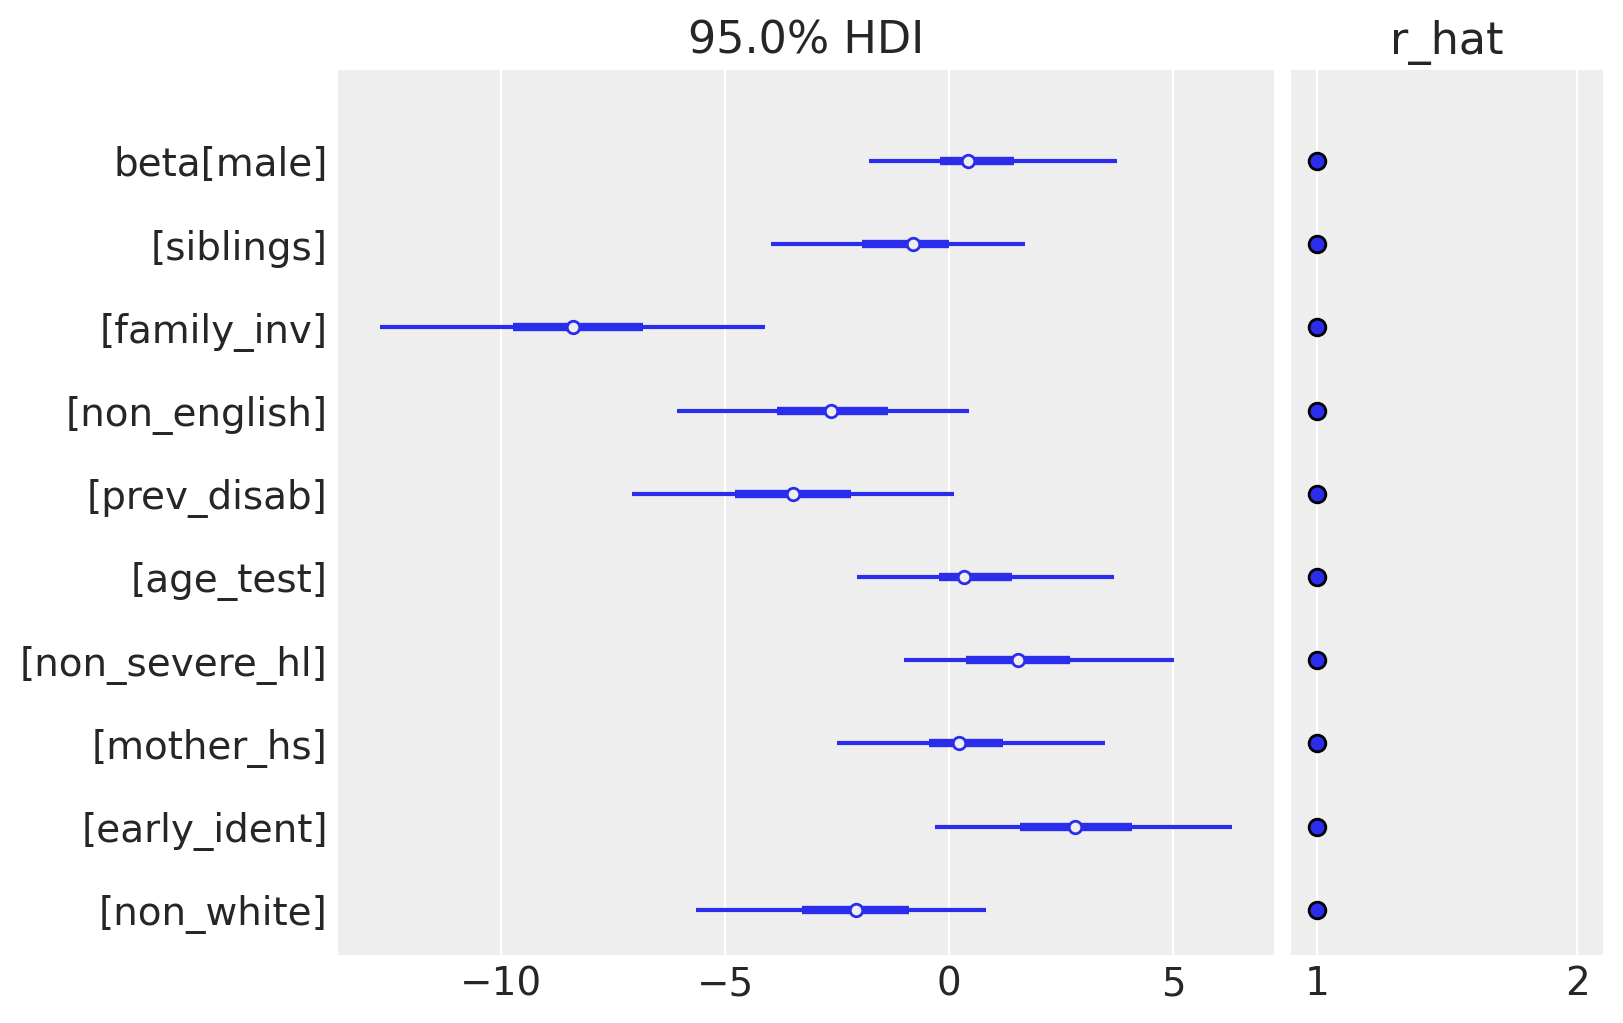

In [29]:
# Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters.
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [ ]:
# the summary function provides a text-based output of common posterior statistics. We select beta estimate only.
az.summary(idata, var_names=["beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[male],0.63,1.36,-1.74,3.50,0.02,0.02,4025.86,3560.15,1.0
beta[siblings],-1.03,1.47,-3.84,1.58,0.02,0.02,3726.18,3720.97,1.0
beta[family_inv],-8.32,2.19,-12.59,-4.35,0.04,0.03,3339.99,3245.19,1.0
beta[non_english],-2.67,1.76,-5.86,0.42,0.03,0.02,3252.20,2255.86,1.0
beta[prev_disab],-3.49,1.89,-6.81,0.15,0.03,0.02,2875.05,1637.81,1.0
beta[age_test],0.61,1.41,-1.91,3.56,0.02,0.02,3907.82,3680.38,1.0
beta[non_severe_hl],1.64,1.61,-0.84,4.97,0.03,0.02,3239.41,3317.12,1.0
beta[mother_hs],0.38,1.47,-2.27,3.44,0.02,0.02,4204.41,3456.14,1.0
beta[early_ident],2.86,1.78,-0.34,6.08,0.03,0.02,2710.23,1594.86,1.0
beta[non_white],-2.18,1.73,-5.65,0.57,0.03,0.02,3644.94,2746.36,1.0


### Case study 2: Coal mining disasters

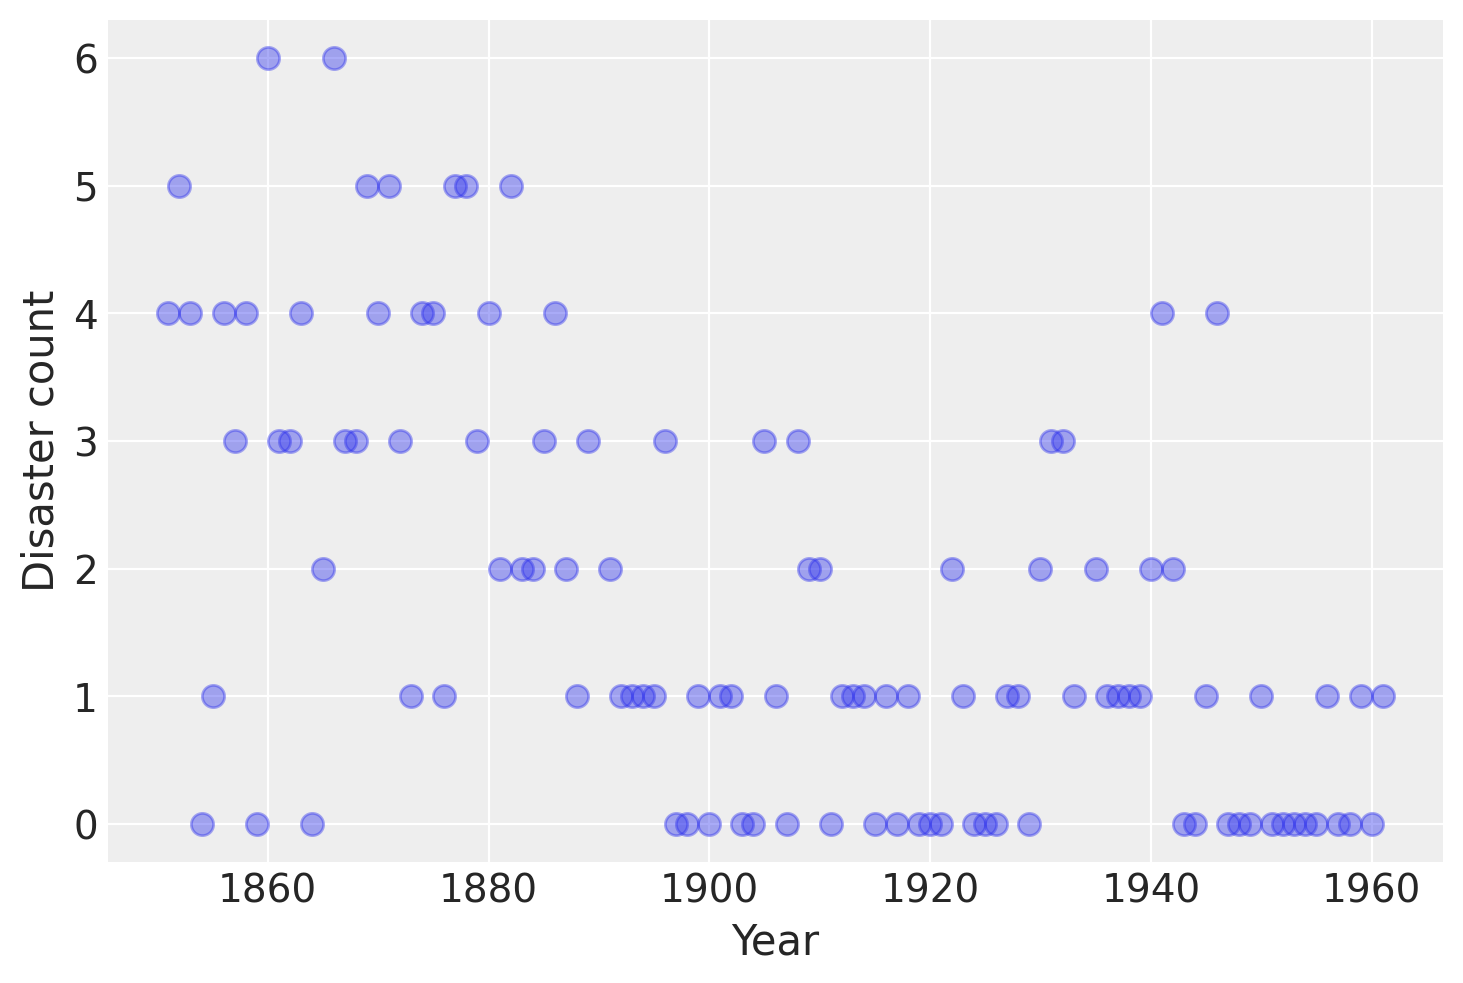

In [ ]:
# Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. 
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:1288: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:1288: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


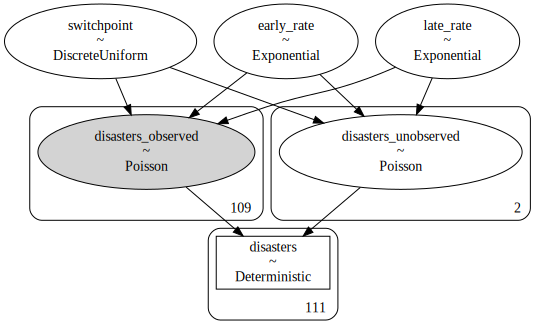

In [ ]:

with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)


    # Allocate appropriate Poisson rates to years before and after current
    # switch function works like an if statement. It uses the first argument to switch between the next two arguments.
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

pm.model_to_graphviz(disaster_model)

In [ ]:
with disaster_model:
    idata = pm.sample(10000)

In [ ]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

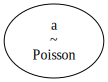

In [60]:
# Arbitrary deterministics
 

from pytensor.compile.ops import as_op


@as_op(itypes=[pt.lscalar], otypes=[pt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3


with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

pm.model_to_graphviz(model_deterministic)

In [ ]:
# Arbitrary distributions
import pytensor.tensor as pt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create variables with custom log-densities
    beta = pm.CustomDist('beta', logp=lambda value: -1.5 * pt.log(1 + value**2))
    eps = pm.CustomDist('eps', logp=lambda value: -pt.log(pt.abs_(value)))
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


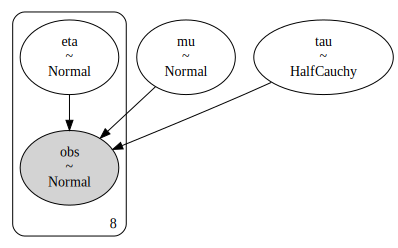

In [ ]:
J = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
# with-statement or context manager, to specify a model object (container for variables and how they related to one another) 
# PyMc variables can not be defined without a corresponding Modle or they have to be put in the with model content.
with pm.Model() as schools:
    # Define priors
    eta = pm.Normal(name="eta", mu=0, sigma=1, shape=J)
    # pm.Normal() arguments include  mu:Mean, sigma:Standard deviation, or tau:Precision (if sigma is not specified)
    intercept = pm.Normal(name="mu", mu=0, sigma=1e6)
    # pymc.HalfCauchy is non-negative and used for standard deviation, similarly Halfnormal
    tau = pm.HalfCauchy(name="tau", beta=25)

    theta = intercept + tau * eta

    obs = pm.Normal(name="obs", mu=theta, sigma=sigma, observed=y)
    
    # inference!
    # trace_h = pm.sample(2000, target_accept=0.9)


pm.model_to_graphviz(schools)



In [3]:
# under the hood they are TensorVariables
type(sigma)

pytensor.tensor.variable.TensorVariable

In [4]:
# all the distribution subclasses included in PyMC have two key methods: random() and logp() which used to generate random values and compute the log-probability of a value, respectively. 
print(
    pm.logp(sigma, 5).eval()   # log-probability
    ,"\n",
     pm.draw(sigma, 5)       # random sample 
)

-2.9773113796684925 
 [  1.88195007   9.22809155  20.01457224 117.08357872  68.95027255]


<Axes: ylabel='Count'>

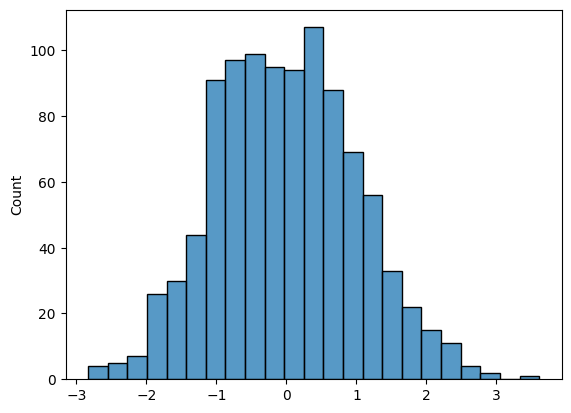

In [5]:
# if you really want to apply the distribution outside of PyMC RV, you need a class method dist()
X = pm.Normal.dist(mu=0, sigma=1, size=1000)
sns.histplot(X.eval())

In [6]:
# list of PyMC distributions
pm.distributions.__all__

['AR',
 'CAR',
 'GARCH11',
 'ICAR',
 'AsymmetricLaplace',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Categorical',
 'Cauchy',
 'Censored',
 'ChiSquared',
 'Continuous',
 'CustomDist',
 'DensityDist',
 'DiracDelta',
 'Dirichlet',
 'DirichletMultinomial',
 'Discrete',
 'DiscreteUniform',
 'DiscreteWeibull',
 'Distribution',
 'EulerMaruyama',
 'ExGaussian',
 'Exponential',
 'Flat',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'HurdleGamma',
 'HurdleLogNormal',
 'HurdleNegativeBinomial',
 'HurdlePoisson',
 'HyperGeometric',
 'Interpolated',
 'InverseGamma',
 'KroneckerNormal',
 'Kumaraswamy',
 'LKJCholeskyCov',
 'LKJCorr',
 'Laplace',
 'LogNormal',
 'Logistic',
 'LogitNormal',
 'Lognormal',
 'MatrixNormal',
 'Mixture',
 'Moyal',
 'Multinomial',
 'MvGaussianRandomWalk',
 'MvNormal',
 'MvStudentT',
 'MvStudentTRandomWalk',
 'NegativeBinomial',
 'Normal',
 'NormalMixture',
 'OrderedLogistic',
 'OrderedMultin

In [ ]:
# every distribution can have batches, vis shape argument
with pm.Model() as fm:
    mu = pm.Normal(name='mu', mu=2500, sigma=100, shape=2)

mu.shape.eval()

array([2])

In [ ]:
# help(pm.HalfNormal)
# we can continue to add more variable with the context manager
with fm:
    sigma = pm.HalfNormal(name='sigma', sigma=100)

 # the model keeps track of the type of variables added
fm.unobserved_RVs   

[mu ~ Normal(2.5e+03, 100), sigma ~ HalfNormal(0, 100)]

In [ ]:
fm.value_vars

# sigma here is sigma_log_, it is just for computation convient and when you get the result of the model it will inverse transform it.


[mu, sigma_log__]

In [18]:
# Just patching the draw function for reproducibility
from functools import partial
rng = np.random.default_rng(seed=sum(map(ord, "dimensionality")))
draw = partial(pm.draw, random_seed=rng)

mvnormal_dist = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3))
mvnormal_draw = draw(mvnormal_dist)
mvnormal_draw, mvnormal_draw.ndim

(array([1.80189558, 0.16145622, 1.04703869]), 1)

8.75

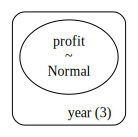

In [ ]:
# The dims argument is an additional human-readable label. When used alone, dims must be combined with explicit shape information.

with pm.Model() as model:
    pm.Normal(name="profit", shape=(3,), dims="year")

pm.model_to_graphviz(model)

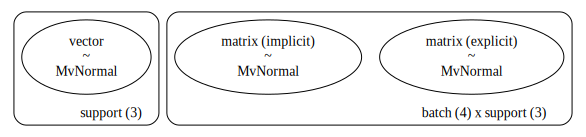

In [16]:
# Where dims can become increasingly powerful is with the use of coords specified in the model itself. In this case the dimensionality of the distribution can actually defined by the dims used. We did not have to pass shape or define implicit batched dimensions.

coords = {
    "batch": [0, 1, 2, 3],
    "support": ["A", "B", "C"],
}
with pm.Model(coords=coords) as model:
    pm.MvNormal(name="vector", mu=[0, 0, 0], cov=np.eye(3), dims=("support",))
    pm.MvNormal(name="matrix (implicit)", mu=np.zeros((4, 3)), cov=np.eye(3), dims=("batch", "support"))
    pm.MvNormal(
        name="matrix (explicit)", mu=[0, 0, 0], cov=np.eye(3), shape=(4, 3), dims=("batch", "support")
    )

pm.model_to_graphviz(model)

### [Model comparison](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html) 

In [27]:
# The data include the observed treatment effects (y) and associated standard deviations (sigma) in the 8 groups.
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


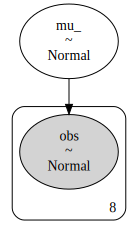

In [ ]:
# pooled model
with pm.Model() as pooled:
    # conjugate prior (Latent pooled effect size)
    muu = pm.Normal(name="mu", mu=0, sigma=1e6) 
    # conjugate distribution with data
    obs = pm.Normal(name="obs", mu=muu, sigma=sigma, observed=y) 
    # 
    trace_p = pm.sample(2000)
    
pm.model_to_graphviz(pooled)

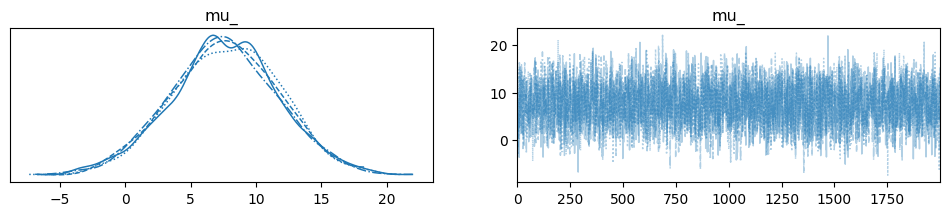

In [44]:
az.plot_trace(trace_p);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


/mnt/e/zhaohuiwang/dev/bayesian-playground/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


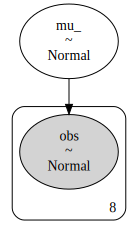

In [ ]:
# Hierarchical model
with pm.Model() as hierarchical:

    eta = pm.Normal(name="eta", mu=0, sigma=1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal(name="mu", mu=0, sigma=10)
    tau = pm.HalfNormal(name="tau", sigma=10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)
    # pymc.Deterministic creates a named deterministic variable. It is generally used to record an intermediary result. It is equivalent, from a mathematical point of view, to theta = mu + tau * eta

    obs = pm.Normal(name="obs", mu=theta, sigma=sigma, observed=y)

    trace_h = pm.sample(2000, target_accept=0.9)



pm.model_to_graphviz(pooled)

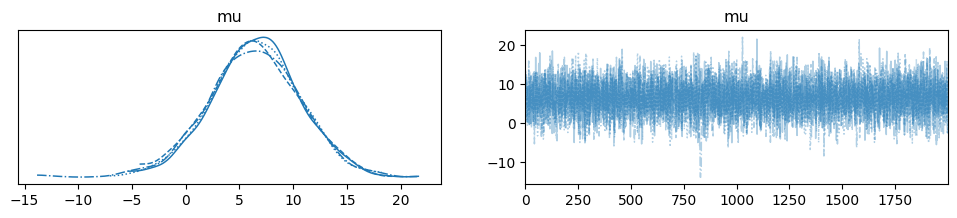

In [49]:
az.plot_trace(trace_h, var_names="mu");

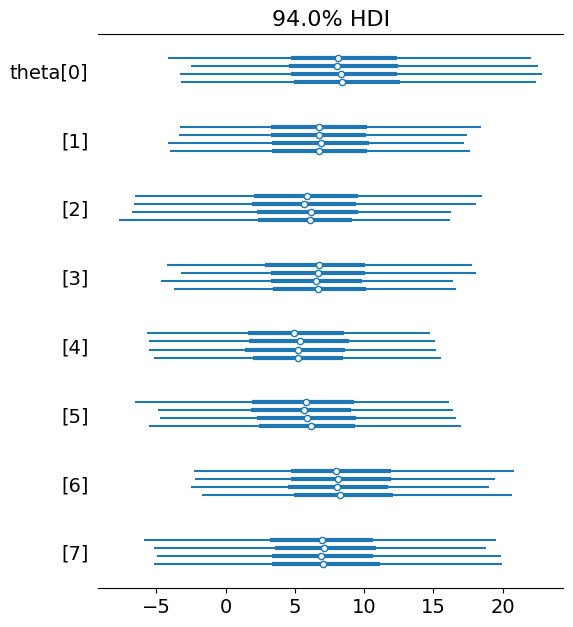

In [50]:
az.plot_forest(trace_h, var_names="theta");

In [ ]:
with pooled:
    pm.compute_log_likelihood(trace_p)

pooled_loo = az.loo(trace_p)
pooled_loo

In [ ]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

hierarchical_loo = az.loo(trace_h)
hierarchical_loo

In [56]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.585867,0.691644,0.000000,1.0,1.115441,0.000000,False,log
hierarchical,1,-30.780945,1.121412,0.195078,0.0,1.076734,0.215664,False,log


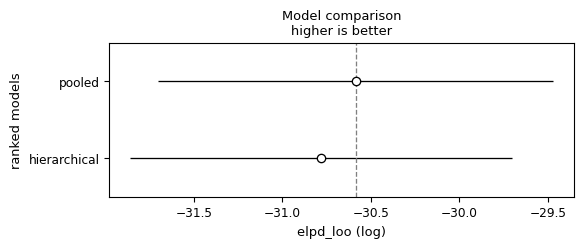

In [57]:
az.plot_compare(df_comp_loo, insample_dev=False);